In [1]:
!pip3 install imutils
# !pip3 install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=6fc64fddfe28e1e39c61a971eec6fdb2b2778dee811e7ef054dcfe4ba7788579
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
# from fast_ml.model_development import train_valid_test_split

In [8]:
data_dir= '/kaggle/input/fall-mog-halfdata/data'

In [9]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(data_dir))
data = []
labels = []

for imagePath in imagePaths:

	label = imagePath.split(os.path.sep)[-2]


	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))


	data.append(image)
	labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


In [10]:

# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, labels, train_size=0.8, valid_size=0.1, test_size=0.1)

from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(data,labels, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [18]:
print(len(X_train))
# print(len(y_train))

print(len(X_valid))
# print(len(y_valid))

print(len(X_test))
# print(len(y_test))



1760
220
221


In [14]:
# (trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [19]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head fully connected layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

2023-01-07 17:40:48.664074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:40:48.665127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:40:48.826757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:40:48.827800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:40:48.828661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [20]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [21]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [22]:
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [24]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_valid, y_valid),
# 	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


2023-01-07 17:41:28.439751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2023-01-07 17:41:30.610605: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


220/220 [==============================] - 44s 153ms/step - loss: 0.6461 - accuracy: 0.6642 - val_loss: 0.5445 - val_accuracy: 0.7364
Epoch 2/25
220/220 [==============================] - 22s 102ms/step - loss: 0.4876 - accuracy: 0.8165 - val_loss: 0.3939 - val_accuracy: 0.8955
Epoch 3/25
220/220 [==============================] - 22s 101ms/step - loss: 0.3939 - accuracy: 0.8642 - val_loss: 0.3070 - val_accuracy: 0.9182
Epoch 4/25
220/220 [==============================] - 22s 99ms/step - loss: 0.3378 - accuracy: 0.8824 - val_loss: 0.2659 - val_accuracy: 0.9136
Epoch 5/25
220/220 [==============================] - 23s 102ms/step - loss: 0.2925 - accuracy: 0.9011 - val_loss: 0.2260 - val_accuracy: 0.9273
Epoch 6/25
220/220 [==============================] - 22s 100ms/step - loss: 0.2668 - accuracy: 0.9034 - val_loss: 0.2066 - val_accuracy: 0.9364
Epoch 7/25
220/220 [==============================] - 22s 102ms/step - loss: 0.2386 - accuracy: 0.9182 - val_loss: 0.1933 - val_accuracy: 0.94

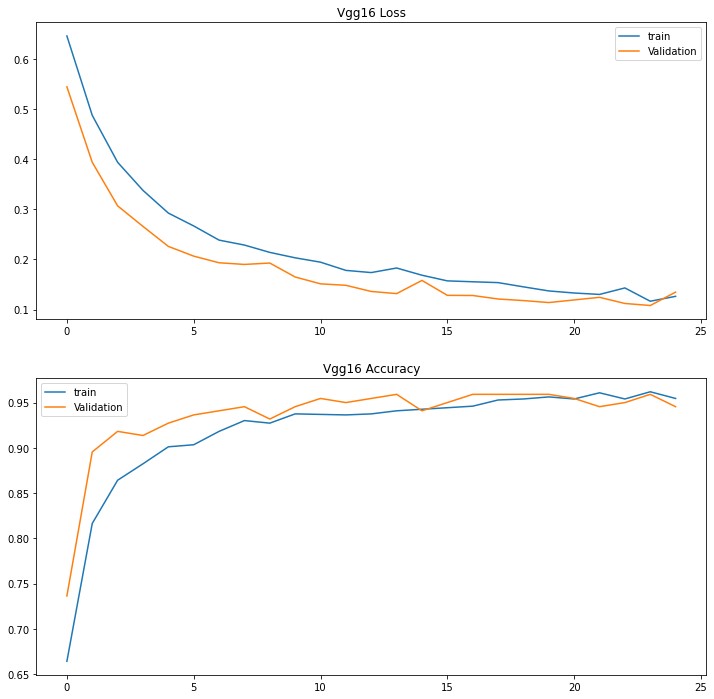

In [25]:
from matplotlib import pyplot
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(H.history['loss'], label='train')
pyplot.plot(H.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(H.history['accuracy'], label='train')
pyplot.plot(H.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()

**Save Model**

In [33]:
model.save('BEST_model.h5')

In [34]:
from keras.models import load_model
model = load_model('BEST_model.h5')

In [37]:
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image

test_image = image.load_img('/kaggle/input/fall-mog-halfdata/data/fall/0880m.jpg',target_size=[224,224])
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)

In [38]:
result

array([[9.9998581e-01, 1.4129959e-05]], dtype=float32)

**EVALUAtE MODEL**

In [42]:
ev_model = load_model('BEST_model.h5')

# #Evaluating using Keras model_evaluate:
loss, acc = ev_model.evaluate(X_test, y_test, batch_size=64)

print("Accuracy: " ,acc)
print("Loss: ", loss)

4/4 [==============================] - 17s 2s/step - loss: 0.1981 - accuracy: 0.9412
Accuracy:  0.9411764740943909
Loss:  0.19814519584178925
